<ipython-input-5-63e14c46b74d>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(ckpt_path)


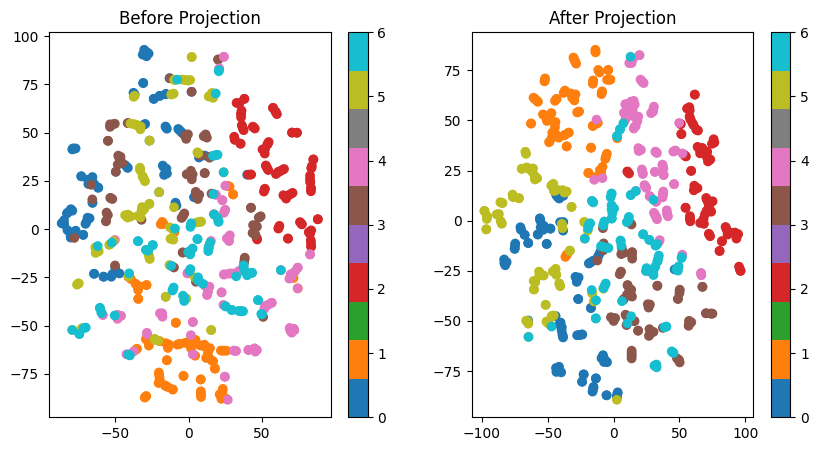

In [5]:
from text_net.DGRN import TextProjectionHead

import torch
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import clip

# 학습된 모델 ckpt 불러오기
ckpt_path = "ckpt/Denoise/epoch_196.pth"  # 학습된 모델의 체크포인트 경로
checkpoint = torch.load(ckpt_path)

# print(checkpoint.keys())

clip_model, preprocess = clip.load("ViT-B/32", device='cuda')
# 동적으로 텍스트 임베딩 차원 가져오기
text_embed_dim = clip_model.text_projection.shape[1]

# Projection Head와 관련된 가중치 불러오기
projection_head = TextProjectionHead(text_embed_dim, 64).cuda()
# 특정 경로에서 가중치 가져오기
projection_head_state_dict = {
    'proj.0.weight': checkpoint['R.body.4.body.4.dgm2.sft.text_proj_head.proj.0.weight'],
    'proj.0.bias': checkpoint['R.body.4.body.4.dgm2.sft.text_proj_head.proj.0.bias'],
    'proj.2.weight': checkpoint['R.body.4.body.4.dgm2.sft.text_proj_head.proj.2.weight'],
    'proj.2.bias': checkpoint['R.body.4.body.4.dgm2.sft.text_proj_head.proj.2.bias'],
}

# Projection Head에 해당 가중치 로드
projection_head.load_state_dict(projection_head_state_dict)

# t-SNE 시각화를 위한 함수 정의
def plot_tsne(original_embeddings, projected_embeddings, labels):
    # t-SNE 적용: 2D로 변환
    tsne = TSNE(n_components=2, random_state=42, perplexity=2)
    original_tsne = tsne.fit_transform(original_embeddings)
    projected_tsne = tsne.fit_transform(projected_embeddings)

    # 시각화
    plt.figure(figsize=(10, 5))

    # 원본 임베딩 시각화
    plt.subplot(1, 2, 1)
    plt.scatter(original_tsne[:, 0], original_tsne[:, 1], c=labels, cmap='tab10')
    plt.title("Before Projection")
    plt.colorbar()

    # Projection Head 거친 후 임베딩 시각화
    plt.subplot(1, 2, 2)
    plt.scatter(projected_tsne[:, 0], projected_tsne[:, 1], c=labels, cmap='tab10')
    plt.title("After Projection")
    plt.colorbar()

    plt.show()

# 모든 텍스트 프롬프트 리스트 생성
text_prompts = haze_text + rain_text + low_text + low_haze_text + low_rain_text + haze_rain_text + low_haze_rain_text

# CLIP 모델로부터 텍스트 임베딩 추출
text_tokens = clip.tokenize(text_prompts).cuda()
with torch.no_grad():
    original_embeddings = clip_model.encode_text(text_tokens)  # 원본 텍스트 임베딩

# 학습된 Projection Head를 거친 후 임베딩
projected_embeddings = projection_head(original_embeddings).detach().cpu().numpy()

# 원본 임베딩은 그대로 사용 (detach() 추가)
original_embeddings = original_embeddings.detach().cpu().numpy()

# 레이블 정의 (0: haze, 1: rain, 2: low)
# text_len = 21
labels = [0] * len(haze_text) + [1] * len(rain_text) + [2] * len(low_text) \
         + [3] * len(low_haze_text) + [4] * len(low_rain_text) + [5] * len(haze_rain_text) + [6] * len(low_haze_rain_text)  # 각 클래스에 대해 10개의 레이블 부여

# t-SNE 시각화 수행
plot_tsne(original_embeddings, projected_embeddings, labels)

In [ ]:
import json

haze_text = [
    "Please remove the haze from the image.",
    "Clear the foggy scene to enhance visibility.",
    "Eliminate the haze to make the image clearer.",
    "Restore the image by removing the haze.",
    "Remove the fog to reveal the hidden details.",
    "Dissipate the haze and enhance the sharpness.",
    "Reduce the haze effect and restore clarity.",
    "Eliminate the foggy layer from the scene.",
    "Clear the haze to improve the overall sharpness.",
    "Make the image sharper by removing the haze.",

    "Remove the mist to reveal the fine details.",
    "Clear the haze for better visibility.",
    "Make the scene clearer by eliminating the fog.",
    "Enhance the visibility by removing the haze.",
    "Remove the foggy effect to make the image crisper.",
    "Get rid of the haze to make the image more distinct.",
    "Erase the fog to enhance the scene's clarity.",
    "Clear the foggy areas to show hidden elements.",
    "Restore the image by eliminating the haze.",
    "Dissolve the fog for a sharper view.",
    
    "Enhance image clarity by reducing haze.",
    "Make the image clearer by dissipating the fog.",
    "Clear the haze and reveal more of the scene.",
    "Remove the fog and bring out the hidden details.",
    "Clear the scene of haze for better sharpness.",
    "Eliminate the hazy layer to restore clarity.",
    "Reduce the mist and enhance the image quality.",
    "Get rid of the haze to sharpen the view.",
    "Clear the fog and bring out the fine details.",
    "Remove the haze to show the scene more clearly.",
    
    "Improve the image by eliminating the fog.",
    "Remove the mist and reveal more of the scene.",
    "Clear the foggy layer for sharper visibility.",
    "Make the image clearer by removing haze.",
    "Dissolve the haze and sharpen the scene.",
    "Enhance the scene by eliminating the fog.",
    "Remove the foggy layer and improve clarity.",
    "Get rid of the haze for a better view.",
    "Restore the scene by clearing the haze.",
    "Eliminate the fog and reveal more details.",
    
    "Reduce the fog effect to sharpen the image.",
    "Remove the mist to bring out the hidden details.",
    "Clear the haze for a crisper view.",
    "Erase the fog to make the image sharper.",
    "Clear the scene of haze for better clarity.",
    "Eliminate the haze for clearer visibility.",
    "Remove the fog to improve the image’s details.",
    "Dissipate the haze to make the image more distinct.",
    "Get rid of the mist for a sharper scene.",
    "Clear the fog and restore the scene’s vibrancy.",

    "Make the image more visible by removing fog.",
    "Reduce the haziness and restore visibility.",
    "Eliminate the fog to make the scene clearer.",
    "Restore the image by reducing haze.",
    "Clear the fog and bring out more of the scene.",
    "Get rid of the haze for sharper visibility.",
    "Dissolve the mist and enhance image clarity.",
    "Remove the foggy layer to improve the image.",
    "Clear the fog to make the image look crisper.",
    "Eliminate the haze for a sharper view.",

    "Reduce the fog to enhance image sharpness.",
    "Clear the haze and restore the scene.",
    "Remove the fog to reveal more details.",
    "Make the image more distinct by clearing fog.",
    "Erase the haze for better visibility.",
    "Reduce the fog and sharpen the image quality.",
    "Clear the haze for a better overall image.",
    "Dissipate the fog and reveal more of the scene.",
    "Make the scene clearer by removing the haze.",
    "Clear the fog to improve the image's quality.",

    "Remove the haze and show the hidden details.",
    "Eliminate the fog for a sharper image.",
    "Restore the image by clearing the haze.",
    "Reduce the mist to improve the image clarity.",
    "Clear the fog for a crisper scene.",
    "Get rid of the haze to make the scene clearer.",
    "Dissolve the haze and improve the view.",
    "Clear the fog to enhance the sharpness.",
    "Remove the mist and make the image more distinct.",
    "Make the image clearer by removing the fog.",

    "Eliminate the haze to improve the visibility.",
    "Clear the haze and reveal the fine details.",
    "Reduce the fog to restore image quality.",
    "Clear the foggy areas to enhance sharpness.",
    "Remove the mist and reveal more of the scene.",
    "Make the image more visible by eliminating fog.",
    "Erase the fog to improve the image clarity.",
    "Clear the haze for a sharper image.",
    "Eliminate the haze for better visibility.",
    "Get rid of the fog and sharpen the scene.",

    "Clear the haze and make the image crisper.",
    "Remove the mist and enhance the scene clarity.",
    "Clear the foggy areas for better sharpness.",
    "Reduce the haze to improve image quality.",
    "Get rid of the fog to make the scene clearer.",
    "Remove the mist and enhance the image quality.",
    "Eliminate the haze to show more details.",
    "Clear the fog and restore the image quality.",
    "Reduce the haze and make the image clearer.",
    "Get rid of the mist for sharper visibility."
]

rain_text = [
    "Please remove the raindrops from the image.",
    "Clean up the rain effect to make the image clear.",
    "Remove the rain from the scene to reveal more details.",
    "Eliminate the rain to restore a clearer image.",
    "Get rid of the rain to improve the clarity of the image.",
    "Remove the rain and make the scene sharper.",
    "Erase the rain effect to make the image clean.",
    "Restore the image by removing the rain.",
    "Clear the rain from the scene and reveal more details.",
    "Eliminate the rain and improve the image quality.",

    "Remove the raindrops to enhance the image sharpness.",
    "Clear the rain for a clearer and crisper scene.",
    "Dissipate the rain to make the scene more visible.",
    "Eliminate the rain to reveal hidden parts of the image.",
    "Get rid of the raindrops for better clarity.",
    "Remove the rain effect to enhance the scene.",
    "Erase the rain and make the image cleaner.",
    "Clean the raindrops to sharpen the image.",
    "Remove the rain from the image to enhance clarity.",
    "Eliminate the rain effect to make the image look sharper.",
    
    "Clear the rain and enhance the scene details.",
    "Remove the rain for improved visibility.",
    "Get rid of the raindrops to reveal more of the scene.",
    "Eliminate the rain and make the image clearer.",
    "Clear the rain from the image for a sharper view.",
    "Remove the rain and restore image clarity.",
    "Erase the raindrops to make the image sharper.",
    "Clear the rain effect for better sharpness.",
    "Remove the rain to reveal finer details.",
    "Get rid of the rain effect and restore the scene.",
    
    "Eliminate the raindrops to make the image cleaner.",
    "Remove the rain and improve the visibility of the scene.",
    "Clear the rain for enhanced sharpness.",
    "Dissipate the rain effect and reveal hidden details.",
    "Erase the rain and bring out the details in the image.",
    "Remove the raindrops to make the scene clearer.",
    "Clear the rain from the scene for better clarity.",
    "Eliminate the rain and sharpen the image.",
    "Get rid of the rain effect to enhance the image quality.",
    "Clear the rain to make the scene more distinct.",
    
    "Remove the raindrops and reveal hidden parts of the image.",
    "Eliminate the rain for a cleaner, sharper view.",
    "Remove the rain and restore the clarity of the image.",
    "Erase the rain effect for a more visible scene.",
    "Clear the rain and make the image look crisper.",
    "Remove the raindrops to improve the scene clarity.",
    "Eliminate the rain and bring out hidden details.",
    "Get rid of the rain to make the image look clearer.",
    "Erase the rain effect for better sharpness.",
    "Remove the rain to reveal the details of the image.",

    "Clear the rain and restore the image quality.",
    "Eliminate the raindrops to enhance the scene.",
    "Get rid of the rain effect for improved clarity.",
    "Remove the rain and sharpen the image quality.",
    "Clear the rain to make the image clearer.",
    "Erase the rain and reveal the hidden details.",
    "Remove the raindrops to enhance the sharpness of the image.",
    "Get rid of the rain for better visibility.",
    "Eliminate the rain for a more distinct view.",
    "Clear the rain from the scene for improved clarity.",

    "Remove the raindrops to make the image look sharper.",
    "Erase the rain effect to make the scene clearer.",
    "Clear the rain and make the image sharper.",
    "Remove the rain to reveal more of the image.",
    "Eliminate the rain and improve the clarity of the scene.",
    "Get rid of the rain effect for better sharpness.",
    "Remove the rain and make the image clearer.",
    "Clear the rain from the scene for better sharpness.",
    "Eliminate the raindrops to make the scene more visible.",
    "Get rid of the rain for a sharper image.",
    
    "Erase the rain to enhance the visibility.",
    "Clear the rain effect and reveal more of the scene.",
    "Remove the rain to make the image sharper.",
    "Eliminate the raindrops for better clarity.",
    "Remove the rain and reveal hidden details.",
    "Clear the rain for a cleaner scene.",
    "Dissipate the rain and make the image clearer.",
    "Get rid of the rain and reveal more of the image.",
    "Clear the rain from the scene to improve visibility.",
    "Remove the raindrops to make the image crisper.",
    
    "Eliminate the rain effect for enhanced clarity.",
    "Get rid of the rain and bring out hidden details.",
    "Clear the rain for a more visible scene.",
    "Remove the raindrops to make the scene clearer.",
    "Erase the rain effect for a sharper image.",
    "Clear the rain from the scene for improved sharpness.",
    "Remove the raindrops and make the image clearer.",
    "Eliminate the rain and make the scene sharper.",
    "Clear the rain effect for better visibility.",  
    "Remove the rain and bring out more details.",

    "Get rid of the rain for enhanced clarity.",
    "Remove the raindrops to make the image sharper.",
    "Eliminate the rain effect and sharpen the scene.",
    "Clear the rain from the image to enhance clarity.",
    "Get rid of the rain and make the image clearer.",
    "Remove the rain effect to improve the scene clarity.",
    "Erase the raindrops for a cleaner image.",
    "Remove the rainfall effect to restore image clarity.",
    "Clear the raindrops to enhance the overall sharpness.",
    "Get rid of the rain to reveal finer image details."
]

low_text = [
    "Brighten up the image to improve visibility.",
    "Enhance the lighting in the dark areas of the image.",
    "Increase the brightness to reveal more details.",
    "Make the dark areas of the image clearer.",
    "Improve the clarity by increasing the brightness.",
    "Lighten up the image to restore hidden details.",
    "Restore the dark areas of the image by brightening them.",
    "Improve visibility in the low-light regions of the image.",
    "Enhance the dark scene to reveal more information.",
    "Increase the brightness to improve the overall clarity.",
    "Brighten the dark regions for a clearer view.",
    "Boost the lighting in the image for better sharpness.",
    "Make the dim areas of the scene more visible.",
    "Increase the brightness to show hidden details.",
    "Lighten up the darker parts of the image.",
    "Improve visibility in the shadows by increasing brightness.",
    "Enhance the low-light parts for better clarity.",
    "Make the scene brighter to improve its clarity.",
    "Reveal the details by increasing the brightness.",
    "Lighten the image for better overall visibility.",
    "Enhance the darker regions for better sharpness.",
    "Increase the lighting to make the scene clearer.",
    "Brighten the shadowed areas to reveal more details.",
    "Boost the brightness to bring out the hidden elements.",
    "Improve the clarity in the dark regions of the image.",
    "Make the dark areas of the image stand out more.",
    "Enhance visibility in the low-light parts of the image.",
    "Make the image brighter to reveal hidden details.",
    "Increase the brightness to improve the image's quality.",
    "Brighten the dim parts of the scene to improve clarity.",
    "Make the darker areas more visible by boosting the brightness.",
    "Improve visibility in the dark regions of the image.",
    "Enhance the details in the shadows by increasing lighting.",
    "Boost the brightness to make the scene more visible.",
    "Lighten up the image to reveal more of the scene.",
    "Improve the scene by increasing the brightness.",
    "Make the dim parts of the image clearer by brightening them.",
    "Enhance visibility in the low-light areas of the image.",
    "Increase the lighting to reveal the hidden details.",
    "Brighten the dark parts of the image for better clarity.",
    "Improve the clarity of the image by increasing brightness.",
    "Boost the lighting in the shadowed regions.",
    "Light up the darker parts of the image for better visibility.",
    "Increase the brightness to make the scene more distinct.",
    "Improve the visibility of the dark regions by lighting them up.",
    "Enhance the clarity in the dim parts of the image.",
    "Brighten the shadows to reveal the hidden details.",
    "Make the dark areas of the image clearer by brightening them.",
    "Increase the brightness to improve overall clarity.",
    "Boost the lighting in the image for better sharpness.",
    "Lighten up the dim areas for improved visibility.",
    "Enhance the scene by increasing the brightness.",
    "Make the darker parts of the image more visible.",
    "Reveal the hidden details by increasing the brightness.",
    "Light up the shadowed regions for better clarity.",
    "Enhance visibility in the low-light regions by brightening them.",
    "Increase the brightness to make the image more visible.",
    "Lighten the dim regions of the image to reveal more details.",
    "Improve the clarity in the dark parts by increasing brightness.",
    "Brighten the dark areas of the image for a clearer view.",
    "Increase the lighting to bring out the hidden details.",
    "Enhance visibility in the shadowed regions of the image.",
    "Brighten the low-light parts for better overall sharpness.",
    "Improve the clarity of the dim parts by increasing brightness.",
    "Boost the brightness to reveal more details in the image.",
    "Light up the dark areas to improve visibility.",
    "Enhance the visibility in the image by increasing the brightness.",
    "Increase the lighting in the darker regions for better clarity.",
    "Brighten the shadows to reveal the fine details.",
    "Make the dim areas more visible by increasing the brightness.",
    "Improve visibility in the low-light areas for better clarity.",
    "Lighten up the image to make the scene clearer.",
    "Increase the brightness to improve the overall sharpness.",
    "Enhance the image by boosting the brightness in dark areas.",
    "Make the darker regions stand out by increasing lighting.",
    "Light up the scene to reveal the hidden details.",
    "Boost the brightness to enhance the visibility of the image.",
    "Increase the lighting in the shadowed areas for better clarity.",
    "Make the dark areas more visible by increasing the brightness.",
    "Enhance the dim parts of the image for better clarity.",
    "Brighten the shadows to make the image clearer.",
    "Increase the brightness to reveal hidden elements in the image.",
    "Lighten the darker regions for improved sharpness.",
    "Improve visibility by brightening the dark areas.",
    "Increase the brightness to make the scene more distinct.",
    "Lighten up the image to reveal the hidden parts.",
    "Enhance the visibility by increasing the lighting.",
    "Boost the brightness in the shadowed regions to reveal details.",
    "Increase the lighting in the image for better visibility.",
    "Make the dim areas clearer by boosting the brightness.",
    "Improve the clarity of the shadows by increasing brightness.",
    "Light up the dark parts of the image to reveal more details."
]

haze_rain_text = [
    "Please remove the haze and rain from the image.",
    "Eliminate both rain and fog to enhance the image clarity.",
    "Clear the rain and haze for a sharper image.",
    "Restore the scene by removing the haze and rain.",
    "Get rid of both rain and haze to reveal more details.",
    "Remove the fog and rain to make the image clearer.",
    "Clear the rain and fog for better overall sharpness.",
    "Eliminate the rain and fog to improve the image quality.",
    "Dissipate the haze and rain to reveal hidden details.",
    "Clear the scene of rain and fog for a cleaner view.",
    "Get rid of both rain and fog to restore the scene.",
    "Remove the rain and haze to make the scene more distinct.",
    "Eliminate both haze and rain to enhance visibility.",
    "Restore the image by clearing the rain and fog.",
    "Clear the fog and raindrops for better sharpness.",
    "Remove the haze and rain to reveal finer details.",
    "Clear the rain and fog for a crisper image.",
    "Eliminate both rain and haze for improved visibility.",
    "Get rid of the rain and fog for a clearer scene.",
    "Clear the rain and mist to reveal more of the image.",
    "Dissipate the rain and fog for better clarity.",
    "Eliminate both the rain and fog to restore the image.",
    "Clear the rain and haze to make the scene clearer.",
    "Get rid of the haze and rain for a sharper view.",
    "Remove both rain and haze for better overall clarity.",
    "Eliminate the fog and rain to enhance the scene.",
    "Clear both haze and rain for better visibility.",
    "Remove the rain and mist to make the image clearer.",
    "Dissolve both the rain and fog for a cleaner scene.",
    "Clear the haze and raindrops for better image quality.",
    "Remove both rain and fog to reveal hidden details.",
    "Eliminate the haze and rain to make the scene sharper.",
    "Clear the fog and rain to improve the visibility of the image.",
    "Dissipate the rain and haze to reveal more details.",
    "Remove the haze and rain to make the image clearer.",
    "Clear the fog and rain for enhanced clarity.",
    "Eliminate both rain and haze for a crisper scene.",
    "Restore the image by clearing the rain and fog.",
    "Get rid of the rain and haze for improved sharpness.",
    "Clear both rain and fog to reveal more of the scene.",
    "Eliminate the rain and haze for better visibility.",
    "Remove both rain and fog to sharpen the image.",
    "Clear the rain and fog for improved image quality.",
    "Dissipate the haze and rain for a clearer view.",
    "Clear the scene of both rain and fog for better clarity.",
    "Remove the rain and haze to reveal more of the scene.",
    "Eliminate both haze and rain to make the image sharper.",
    "Clear the rain and fog for better visibility.",
    "Get rid of the rain and haze for a sharper scene.",
    "Dissolve the fog and rain to make the image clearer.",
    "Remove both haze and rain for a clearer scene.",
    "Clear the rain and mist for improved visibility.",
    "Eliminate both the rain and fog for a cleaner image.",
    "Clear the haze and rain for better overall clarity.",
    "Remove both the rain and haze to reveal more details.",
    "Dissipate the rain and fog for improved sharpness.",
    "Clear both haze and rain for a crisper view.",
    "Get rid of the rain and fog to reveal hidden elements.",
    "Remove the haze and rain for better sharpness.",
    "Eliminate the rain and fog for enhanced visibility.",
    "Clear the haze and rain to improve image clarity.",
    "Get rid of both rain and fog for better sharpness.",
    "Remove the fog and rain to make the image more distinct.",
    "Dissipate the haze and rain for a crisper image.",
    "Eliminate both rain and haze to restore the scene.",
    "Clear both the rain and fog to reveal hidden details.",
    "Remove both rain and haze to make the image clearer.",
    "Clear the rain and fog for better overall sharpness.",
    "Dissolve both the rain and mist for improved visibility.",
    "Clear the haze and rain for a sharper view.",
    "Remove the fog and rain to enhance the scene.",
    "Eliminate both the haze and rain for improved clarity.",
    "Clear both rain and haze for a crisper image.",
    "Remove both fog and rain to make the scene sharper.",
    "Dissipate the rain and fog to enhance visibility.",
    "Eliminate both rain and haze to make the image clearer.",
    "Clear the rain and fog for a better view.",
    "Remove the haze and rain to improve the image’s quality.",
    "Clear both the rain and fog to reveal the details.",
    "Get rid of the rain and fog for better sharpness.",
    "Remove the haze and rain to make the scene more distinct.",
    "Dissipate both the rain and fog for improved visibility.",
    "Clear the haze and rain to restore the scene’s clarity.",
    "Eliminate both the rain and haze for a sharper image.",
    "Remove the fog and rain to improve the clarity of the image.",
    "Get rid of both rain and fog to reveal more of the scene.",
    "Clear the haze and rain to make the image look crisper.",
    "Dissipate both the rain and mist to improve sharpness.",
    "Eliminate the haze and rain to reveal hidden details.",
    "Clear both fog and rain for improved image clarity.",
    "Remove both rain and haze to make the image clearer.",
    "Get rid of the rain and fog for a better overall view."
]

low_haze_text = [
    "Remove the haze and brighten up the dark areas.",
    "Clear the fog and increase the brightness for better visibility.",
    "Eliminate both haze and darkness for enhanced clarity.",
    "Remove the haze and lighten the dark regions of the image.",
    "Reduce the fog and brighten the scene for better sharpness.",
    "Dissipate the haze and increase the brightness for a clearer image.",
    "Clear the fog and dark areas for better visibility.",
    "Remove both haze and low light to reveal more details.",
    "Eliminate the fog and brighten the image to enhance clarity.",
    "Clear the haze and brighten the dark regions for better sharpness.",
    "Increase brightness and remove the haze for better visibility.",
    "Dissipate the fog and brighten the dim regions of the image.",
    "Clear the haze and brighten up the shadows for a clearer image.",
    "Remove the mist and increase brightness for better visibility.",
    "Reduce the haze and improve visibility by brightening dark areas.",
    "Clear the fog and lighten up the dim regions for better clarity.",
    "Eliminate both the fog and darkness to restore the scene.",
    "Brighten up the dark areas and remove the haze for better clarity.",
    "Clear both fog and shadows to make the image clearer.",
    "Remove the haze and brighten the dim parts for improved sharpness.",
    "Clear the haze and increase brightness to reveal hidden details.",
    "Dissipate the fog and brighten the image for better visibility.",
    "Remove the mist and lighten the dark areas for improved clarity.",
    "Clear the haze and make the dark areas more visible.",
    "Reduce the fog and shadows to enhance the scene’s clarity.",
    "Eliminate both haze and darkness to reveal hidden details.",
    "Clear the fog and brighten up the scene for a crisper view.",
    "Remove both fog and low light to reveal more of the image.",
    "Brighten up the shadows and clear the haze for better clarity.",
    "Dissipate the fog and lighten up the scene for sharper visibility.",
    "Remove the haze and brighten up the dark regions for better sharpness.",
    "Clear the fog and increase the brightness for more visibility.",
    "Reduce the haze and brighten the dark areas for a clearer image.",
    "Eliminate the fog and shadows to improve the image’s quality.",
    "Clear both haze and darkness to make the scene sharper.",
    "Brighten up the dark regions and remove the haze for better sharpness.",
    "Clear the haze and brighten the dim regions to improve clarity.",
    "Dissipate the fog and brighten up the image to enhance visibility.",
    "Remove both fog and shadows to restore the image’s clarity.",
    "Clear the haze and brighten the dark parts for improved visibility.",
    "Reduce both fog and darkness to make the image clearer.",
    "Brighten the dim areas and clear the haze for better sharpness.",
    "Remove the mist and lighten the shadows for improved visibility.",
    "Clear both fog and low light to reveal hidden details.",
    "Eliminate the haze and brighten the dark regions for better clarity.",
    "Brighten up the scene and dissipate the fog for improved sharpness.",
    "Clear the haze and brighten the dark areas to reveal more details.",
    "Remove both fog and shadows for better overall clarity.",
    "Brighten up the dark parts and clear the haze to enhance visibility.",
    "Clear the fog and dark regions to make the image clearer.",
    "Dissipate the haze and lighten up the scene for improved visibility.",
    "Brighten the image and clear the fog for enhanced sharpness.",
    "Remove both the haze and low light to improve clarity.",
    "Clear the fog and brighten the dim areas for a clearer image.",
    "Brighten the dark regions and eliminate the haze for a sharper view.",
    "Clear the haze and lighten up the scene for better visibility.",
    "Remove both the fog and shadows to reveal more of the scene.",
    "Brighten the image and dissipate the fog for better clarity.",
    "Clear the fog and brighten the dark areas to reveal hidden details.",
    "Remove the haze and brighten the shadows for better sharpness.",
    "Dissipate both the fog and darkness to enhance the image clarity.",
    "Brighten up the dark regions and clear the haze to make the image sharper.",
    "Remove the mist and increase brightness for a crisper view.",
    "Clear both fog and shadows for better visibility in the image.",
    "Brighten the dim parts of the image and clear the haze for better sharpness.",
    "Remove both haze and darkness to reveal more of the scene.",
    "Clear the fog and brighten the dark regions to enhance the clarity.",
    "Dissipate the haze and lighten the dark areas for a clearer image.",
    "Remove the fog and increase brightness for improved visibility.",
    "Clear both haze and low light for a crisper view.",
    "Brighten the dim regions and clear the haze to reveal hidden details.",
    "Clear the fog and lighten the dark regions for better sharpness.",
    "Remove the mist and brighten the image for better visibility.",
    "Dissipate the haze and brighten the dark areas to enhance the clarity.",
    "Clear both fog and shadows to reveal more details in the image.",
    "Brighten the dim regions and clear the haze for improved visibility.",
    "Remove the haze and lighten up the dark areas to improve clarity.",
    "Clear both the fog and shadows to restore the image.",
    "Brighten the dark areas and dissipate the fog for better sharpness.",
    "Remove both fog and low light to enhance the image clarity.",
    "Clear the haze and brighten the dim parts to reveal more of the scene.",
    "Dissipate the fog and brighten the shadows for a crisper view.",
    "Remove the haze and brighten the dark regions for a clearer scene.",
    "Clear both fog and darkness for improved sharpness.",
    "Brighten the dim areas and clear the haze for improved clarity.",
    "Remove the fog and lighten the dark regions to make the image clearer.",
    "Clear both haze and low light to reveal more details in the image."
]


low_rain_text = [
    "Remove the rain and brighten up the dark areas.",
    "Clear the rain and enhance visibility in low-light regions.",
    "Eliminate both rain and darkness for improved clarity.",
    "Remove the rain and lighten the scene for better visibility.",
    "Reduce the rain and increase brightness for a clearer view.",
    "Dissipate the rain and brighten the image for sharper visibility.",
    "Clear the rain and shadows to reveal more details.",
    "Remove both rain and low-light effects to improve the image quality.",
    "Eliminate the rain and brighten the dark regions for a clearer image.",
    "Clear the rain and increase brightness to make the image sharper.",
    "Remove the rain and brighten the shadows for better clarity.",
    "Eliminate both rain and low-light conditions for enhanced visibility.",
    "Clear the rain and improve brightness for a sharper scene.",
    "Remove the rain and brighten the dim regions for better clarity.",
    "Dissipate the rain and lighten up the scene for improved sharpness.",
    "Reduce the rain and dark shadows to improve visibility.",
    "Clear both rain and low-light conditions for better clarity.",
    "Remove the rain and brighten the dark areas for a clearer image.",
    "Clear the rain and shadows to make the image more distinct.",
    "Eliminate both rain and darkness for sharper visibility.",
    "Remove the rain and brighten up the dim areas for better clarity.",
    "Reduce both rain and shadows to reveal more details in the image.",
    "Clear the rain and increase brightness for better visibility.",
    "Dissipate the rain and lighten the dark regions for improved clarity.",
    "Remove the rain and brighten the image to reveal hidden details.",
    "Eliminate the rain and brighten up the dark parts for sharper visibility.",
    "Clear both rain and shadows for better image clarity.",
    "Remove the rain and lighten the shadows to enhance sharpness.",
    "Clear the rain and brighten the image for improved visibility.",
    "Remove both rain and low light to reveal more of the scene.",
    "Dissipate the rain and brighten up the scene for clearer details.",
    "Reduce both rain and shadows for a more distinct image.",
    "Eliminate the rain and brighten the scene to reveal hidden elements.",
    "Clear the rain and improve brightness to enhance the image.",
    "Remove both rain and low-light effects to make the scene clearer.",
    "Brighten up the image and clear the rain for better clarity.",
    "Clear the rain and lighten the dark regions for better visibility.",
    "Dissipate the rain and brighten the shadows for a crisper image.",
    "Remove the rain and improve brightness for better sharpness.",
    "Clear both rain and low-light conditions for a sharper image.",
    "Remove the rain and brighten the dark areas for enhanced clarity.",
    "Clear the rain and dark regions to reveal more of the image.",
    "Eliminate both rain and shadows for improved visibility.",
    "Remove the rain and brighten the shadows for a clearer scene.",
    "Clear both rain and low-light regions to make the scene clearer.",
    "Dissipate the rain and lighten up the dark areas for better clarity.",
    "Remove the rain and brighten the image for a more distinct view.",
    "Eliminate both rain and low light to enhance the scene.",
    "Clear the rain and brighten up the dark parts for sharper details.",
    "Remove both rain and shadows to improve the image quality.",
    "Clear the rain and lighten the dim areas for better clarity.",
    "Dissipate the rain and dark shadows for better visibility.",
    "Remove the rain and brighten the scene for enhanced clarity.",
    "Clear both rain and darkness to reveal more of the scene.",
    "Eliminate the rain and brighten up the shadows for better sharpness.",
    "Remove both rain and low light to make the image sharper.",
    "Clear the rain and lighten the dark areas for improved visibility.",
    "Dissipate the rain and brighten the shadows for a crisper scene.",
    "Remove the rain and brighten the image to reveal hidden details.",
    "Clear both rain and shadows to improve overall clarity.",
    "Eliminate the rain and brighten up the scene for better visibility.",
    "Remove both rain and low light to reveal more of the image.",
    "Clear the rain and lighten the shadows for better sharpness.",
    "Dissipate the rain and brighten up the dim regions for improved visibility.",
    "Remove the rain and lighten the dark parts for clearer details.",
    "Eliminate the rain and brighten the dark areas for a clearer image.",
    "Clear both rain and shadows for enhanced visibility.",
    "Remove the rain and increase brightness to reveal hidden details.",
    "Clear the rain and dark regions to enhance image sharpness.",
    "Dissipate the rain and lighten up the scene for better visibility.",
    "Remove the rain and brighten the shadows to improve clarity.",
    "Clear both rain and darkness for a sharper image.",
    "Eliminate the rain and brighten up the scene for better clarity.",
    "Remove the rain and lighten the dark areas for improved sharpness.",
    "Clear both rain and shadows to make the image clearer.",
    "Dissipate the rain and dark areas to reveal more details.",
    "Remove the rain and brighten up the scene for improved clarity.",
    "Clear both rain and shadows to make the image more distinct.",
    "Eliminate the rain and lighten the dim regions for better clarity.",
    "Remove both rain and darkness for improved sharpness.",
    "Clear the rain and brighten up the shadows to reveal hidden details.",
    "Dissipate the rain and brighten the image for better visibility.",
    "Remove both rain and low light to make the scene clearer.",
    "Clear the rain and lighten the shadows to reveal more of the image.",
    "Eliminate the rain and dark shadows for improved clarity.",
    "Remove both rain and darkness to enhance the image quality.",
    "Clear both rain and shadows to reveal finer details.",
    "Dissipate the rain and brighten the image for a more distinct view.",
    "Remove the rain and brighten the dim parts to enhance sharpness.",
    "Clear both rain and low light for a clearer scene.",
    "Eliminate the rain and brighten the shadows for better sharpness.",
    "Remove both rain and shadows to make the scene clearer.",
    "Clear the rain and lighten the dark areas to enhance the image clarity."
]

low_haze_rain_text = [
    "Remove the haze, rain, and brighten up the dark areas.",
    "Clear the fog, rain, and increase brightness for better visibility.",
    "Eliminate both rain and haze while brightening the image.",
    "Remove the haze and rain, and lighten the dark regions.",
    "Reduce the fog, rain, and shadows to enhance clarity.",
    "Dissipate the rain and fog, and brighten the scene for sharpness.",
    "Clear the rain, haze, and shadows to reveal hidden details.",
    "Remove both rain and fog, and brighten the low-light regions.",
    "Eliminate the rain and haze while increasing brightness for clarity.",
    "Clear the rain, fog, and dark areas for better visibility.",
    "Remove the rain, mist, and brighten the image for clarity.",
    "Dissipate the haze, rain, and lighten the shadows for better sharpness.",
    "Eliminate both rain and fog, and brighten the scene.",
    "Clear the rain, fog, and brighten the dark areas for sharper visibility.",
    "Remove the rain and mist while increasing brightness for a clearer image.",
    "Reduce both rain and haze, and brighten the shadows for better clarity.",
    "Clear the rain, fog, and dark regions for improved visibility.",
    "Eliminate both the rain and haze, and brighten the dim areas.",
    "Remove the rain and fog, and lighten the scene to reveal more details.",
    "Clear both rain and mist while brightening up the shadows.",
    "Dissipate the rain and fog while increasing brightness for better sharpness.",
    "Remove both rain and haze while brightening the dark regions.",
    "Clear the rain, fog, and shadows for better overall clarity.",
    "Eliminate both rain and fog, and lighten the image to reveal hidden details.",
    "Clear the rain and fog while brightening the shadows for better visibility.",
    "Remove the rain, mist, and dark shadows to enhance clarity.",
    "Reduce both rain and haze while brightening the scene.",
    "Clear the rain, fog, and brighten the image for improved visibility.",
    "Dissipate the rain, fog, and brighten the dark regions for better sharpness.",
    "Eliminate both rain and mist while brightening the scene for clarity.",
    "Clear the rain, haze, and shadows for improved visibility.",
    "Remove the rain, fog, and lighten the image for clearer details.",
    "Dissipate both rain and fog while brightening the shadows.",
    "Eliminate both rain and mist, and lighten the dark areas for clarity.",
    "Remove the rain, fog, and increase brightness to improve sharpness.",
    "Clear the rain, mist, and shadows to reveal more of the scene.",
    "Dissipate the rain and haze, and brighten up the dark regions.",
    "Remove both rain and fog, and brighten the shadows for sharper details.",
    "Eliminate the rain, mist, and brighten the scene for a clearer image.",
    "Clear both rain and fog, and lighten the dark areas for improved clarity.",
    "Remove the rain, haze, and brighten the image for better visibility.",
    "Reduce both rain and fog while brightening the shadows for clarity.",
    "Clear the rain and mist, and increase brightness for a sharper view.",
    "Eliminate both rain and fog, and brighten up the scene to reveal more details.",
    "Remove the rain, mist, and lighten the dark regions for better visibility.",
    "Clear both rain and haze while increasing brightness to reveal more details.",
    "Dissipate the rain and fog, and brighten the scene for enhanced clarity.",
    "Remove both rain and mist, and brighten the dark areas for a clearer image.",
    "Clear the rain, fog, and shadows for improved sharpness.",
    "Reduce both rain and fog while brightening the scene to enhance visibility.",
    "Eliminate the rain, fog, and brighten up the dark areas for clarity.",
    "Clear the rain, mist, and brighten the shadows to reveal hidden details.",
    "Dissipate both rain and fog while increasing brightness for a sharper image.",
    "Remove both rain and haze, and brighten the dark regions for better visibility.",
    "Clear the rain, fog, and lighten the shadows for improved sharpness.",
    "Eliminate both rain and fog, and increase brightness for better clarity.",
    "Clear the rain and fog, and brighten the dark areas for a clearer view.",
    "Remove the rain, mist, and shadows for enhanced visibility.",
    "Dissipate both rain and haze, and brighten the dark regions to reveal more details.",
    "Remove the rain, fog, and brighten the shadows for better clarity.",
    "Clear both rain and fog while increasing brightness for sharper visibility.",
    "Eliminate the rain and mist, and brighten the scene for improved sharpness.",
    "Clear the rain, fog, and brighten the dark regions for a clearer image.",
    "Remove the rain, haze, and brighten up the shadows for better clarity.",
    "Dissipate both rain and fog while brightening the dark areas for sharper visibility.",
    "Clear the rain, mist, and lighten the shadows for improved visibility.",
    "Eliminate the rain and fog, and brighten the dark regions to reveal more details.",
    "Remove the rain, mist, and brighten the scene for better clarity.",
    "Clear the rain, fog, and brighten the dark areas to reveal hidden details.",
    "Dissipate both rain and fog while brightening the shadows for enhanced clarity.",
    "Remove the rain, mist, and lighten the dark regions for better visibility.",
    "Clear both rain and haze, and brighten up the shadows to improve clarity.",
    "Reduce both rain and fog while brightening the dark areas for a sharper image.",
    "Eliminate the rain and haze, and lighten the shadows for better sharpness.",
    "Remove both rain and fog, and brighten the scene for improved visibility.",
    "Clear the rain, mist, and brighten the dark regions for a clearer view.",
    "Dissipate the rain and fog, and lighten the shadows for better clarity.",
    "Remove the rain, haze, and brighten the scene for sharper details.",
    "Clear both rain and mist while increasing brightness for enhanced visibility.",
    "Eliminate both rain and fog, and brighten the dark regions for a crisper image.",
    "Clear the rain, haze, and shadows for better visibility.",
    "Dissipate the rain, fog, and brighten the dark areas for better clarity.",
    "Remove the rain, mist, and increase brightness for improved sharpness.",
    "Clear both rain and fog while brightening the shadows to reveal more details.",
    "Reduce the rain and haze, and brighten up the dark regions for better clarity.",
    "Clear the rain and fog, and brighten the dark areas for better visibility."
]


# 딕셔너리로 모든 프롬프트를 묶음
prompts = {
    "haze_text": haze_text,
    "rain_text": rain_text,
    "low_text": low_text,
    "haze_rain_text": haze_rain_text,
    "low_rain_text": low_rain_text,
    "low_haze_text": low_haze_text,
    "low_haze_rain_text": low_haze_rain_text
}

# JSON 파일로 저장
with open('prompts.json', 'w') as json_file:
    json.dump(prompts, json_file, indent=4)